In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!wandb login 9676e3cc95066e4865586082971f2653245f09b4

Appending key for api.wandb.ai to your netrc file: /Users/guydavidson/.netrc
Successfully logged in to Weights & Biases!


In [4]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats, optimize
from scipy.special import factorial

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import path as mpath

import pickle
import tabulate
import wandb
from collections import namedtuple

import meta_learning_data_analysis as analysis
import meta_learning_analysis_plots as plots

In [5]:
np.set_printoptions(linewidth=160)
# Avoid escaping any latex characters
tabulate.LATEX_ESCAPE_RULES = {}

MIN_FONT_SIZE = 14
LABELS_FONT_SIZE = 20
TITLE_FONT_SIZE = 24

matplotlib.rcParams.update({'font.size': MIN_FONT_SIZE})
FONT_DICT = dict(fontsize=LABELS_FONT_SIZE) 
TITLE_FONT_DICT = dict(fontsize=TITLE_FONT_SIZE)

PER_PLOT_WIDTH = 6

QUERY_ORDINAL_POSITION_COMORLAP= 'cool'
NUM_TIMES_TRAINED_COLORMAP = 'copper'

In [6]:
api = wandb.Api()

In [7]:
cache = analysis.refresh_cache()
print(cache.keys())

dict_keys(['six_replications_analyses', 'control_analyses', 'query_mod_replications', 'six_replications_updated_analyses', 'updated_control_analyses', 'query_mod_updated_analyses', 'forgetting_curves_raw_data'])


In [8]:
forgetting_exp_path = 'meta-learning-scaling/sequential-benchmark-forgetting-experiment-revisited'
forgetting_exp_pattern = 'meta-learning-scaling/sequential-benchmark-forgetting-experiment-revisited/{run_id}'

In [9]:
if 'forgetting_curves_raw_data' in cache:
    forgetting_curves_raw_data = cache['forgetting_curves_raw_data']

else:
    forgetting_runs = api.runs(forgetting_exp_path)
    print('Loaded runs')
    
    trajectories = [analysis.parse_forgetting_results(current_run=run) for run in forgetting_runs]
    forgetting_curves_raw_data = np.stack(trajectories)
    cache = analysis.refresh_cache(dict(forgetting_curves_raw_data=forgetting_curves_raw_data))


# Evaluating two different forms of decay curves

In both models, we treat time steps $t \in \{0, 30\}$

## Power function decay:
Fit $\alpha, \beta$:
\begin{align*}
mem =& \alpha (1 + t)^{-\beta} \\
acc =& 0.5 mem + 0.5 \\
acc - 0.5 =& 0.5 \alpha (1 + t)^{-\beta}
\end{align*}

## Exponential decay:
Fit $\alpha, \beta$:
\begin{align*}
mem =& \alpha \exp (-\beta t) \\
acc =& 0.5 mem + 0.5 \\
acc - 0.5 =& 0.5 \alpha \exp (-\beta t) \\
\end{align*}

In [30]:
EPSILON = 1
BASELINE = 0.5
REMAINDER = 1 - BASELINE

def power_decay(x, alpha, beta):
    return REMAINDER * alpha * np.power(x + EPSILON, -beta)

def three_param_power_decay(x, alpha, beta, gamma):
    return REMAINDER * alpha * np.power((beta * x) + EPSILON, -gamma)

def exponential_decay(x, alpha, beta):
    return REMAINDER * alpha * np.exp(-beta * x)

def extract_x_y(data, baseline=BASELINE):
    x = []
    y = []
    for index in np.ndindex(data.shape):
        val = data[index]
        if not np.isnan(val):
            x.append(index[1])
            y.append(val)

    x = np.array(x)
    y = np.array(y)
    return x, y - baseline

def fit_model(data, model, bounds=(-np.inf, np.inf), baseline=BASELINE):
    """
    data is n_replications * n_timesteps, can contain nans
    baseline is what the guessing rate is - 0.5 for binary classification
    """
    x, y = extract_x_y(data, baseline)
    return optimize.curve_fit(model, x, y, maxfev=2000, bounds=bounds)

    

# Data visualization

Solid black line is the mean, cyan area is two SEMs around the mean, now with the fits

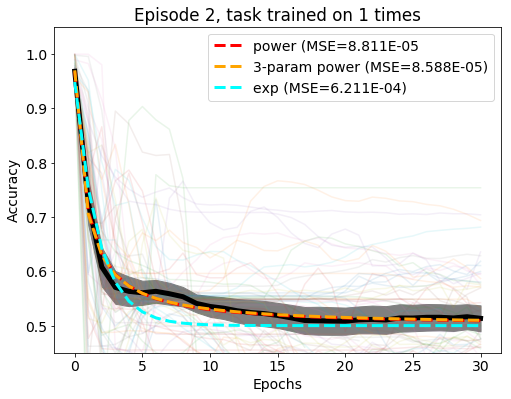

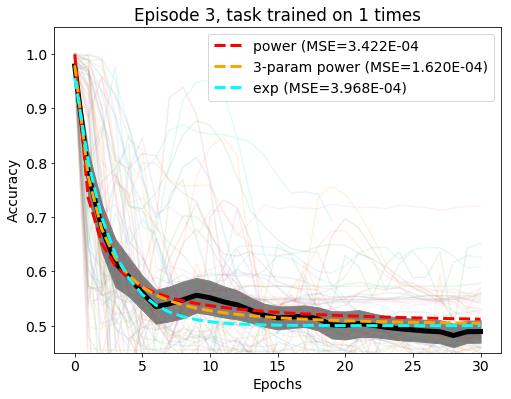

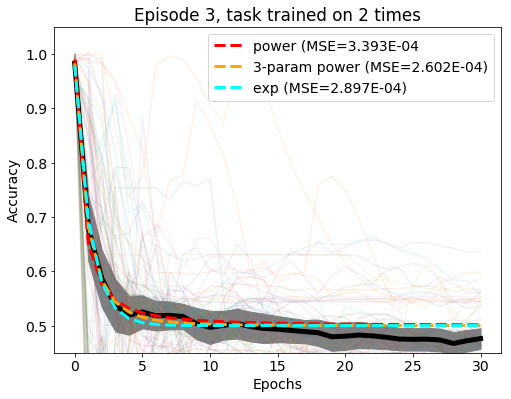

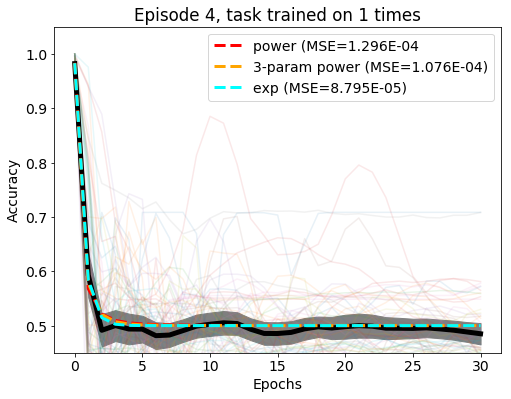

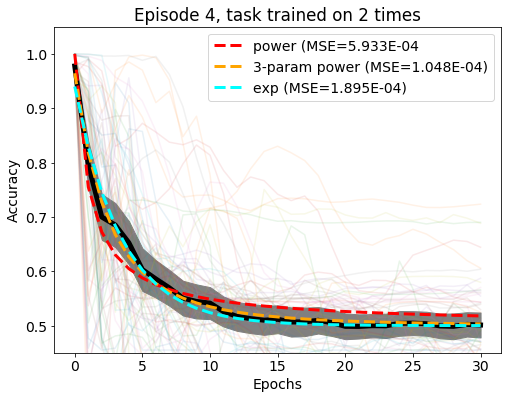

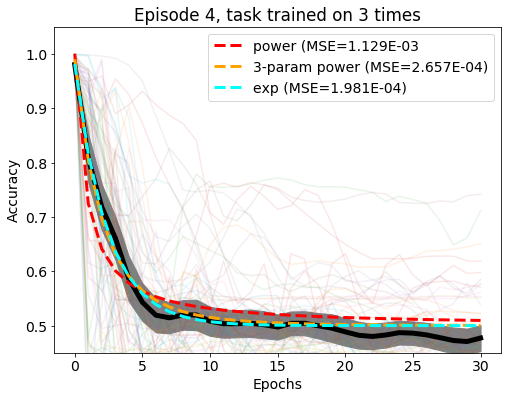

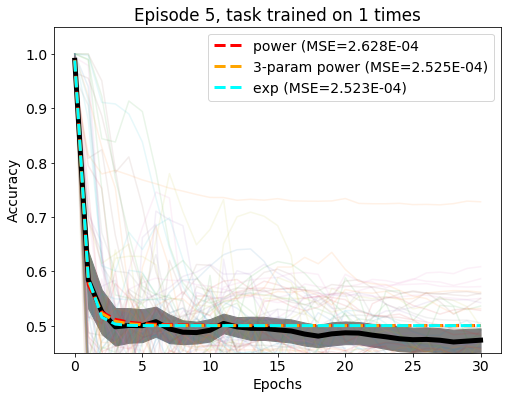

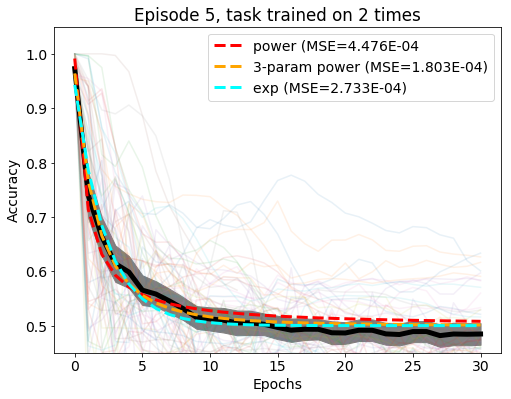

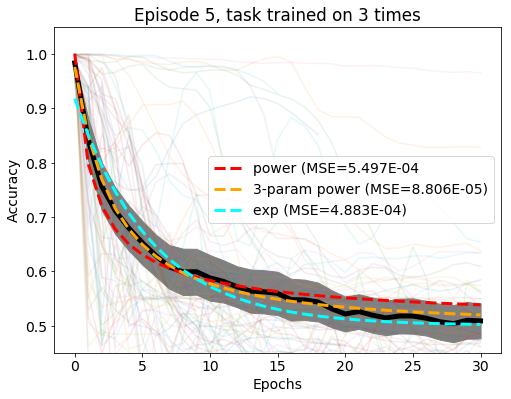

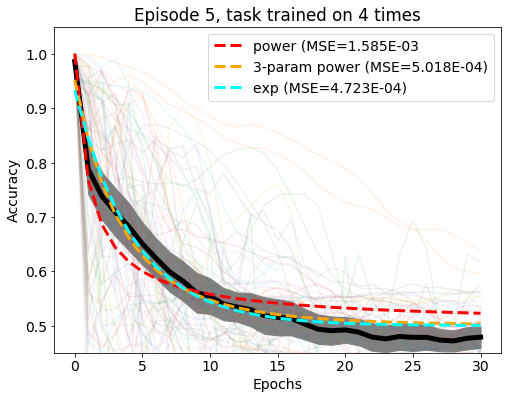

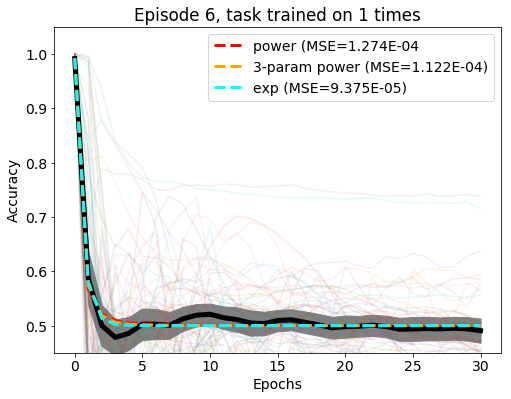

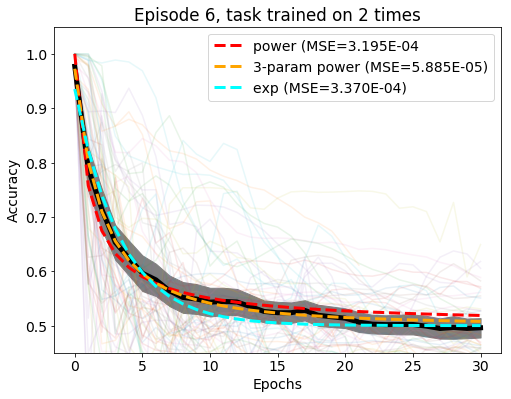

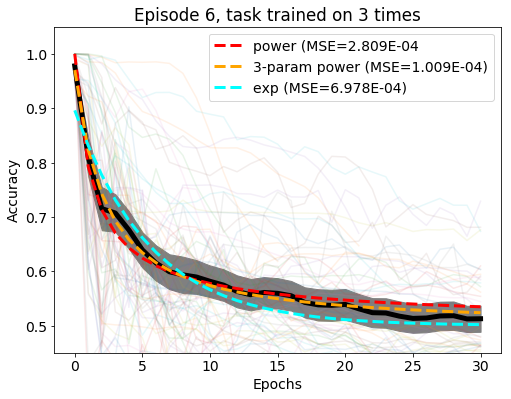

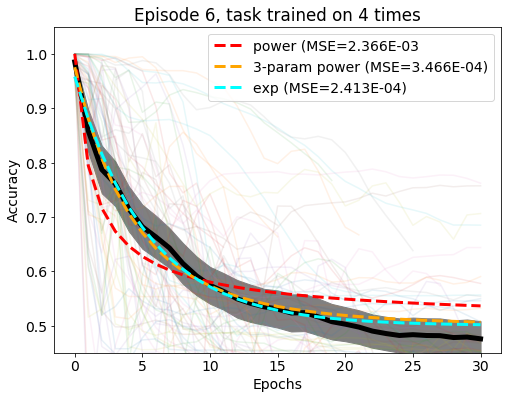

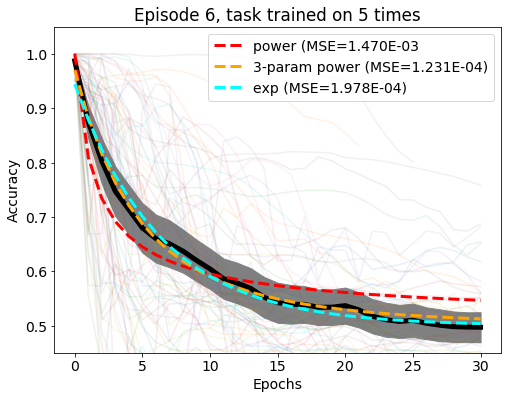

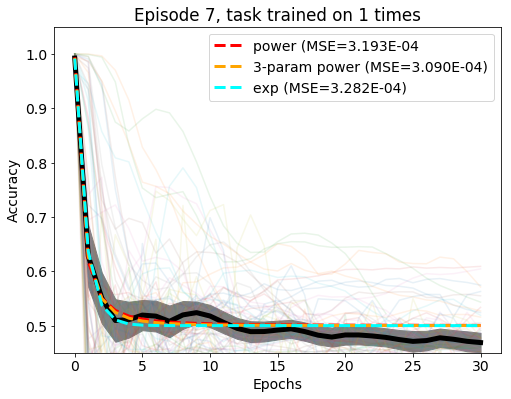

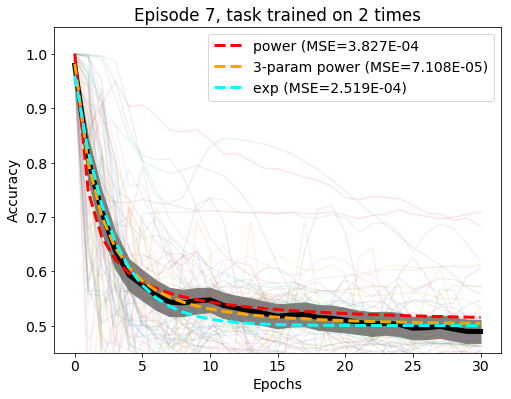

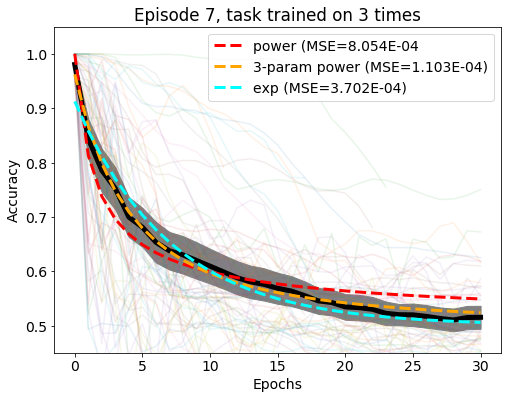

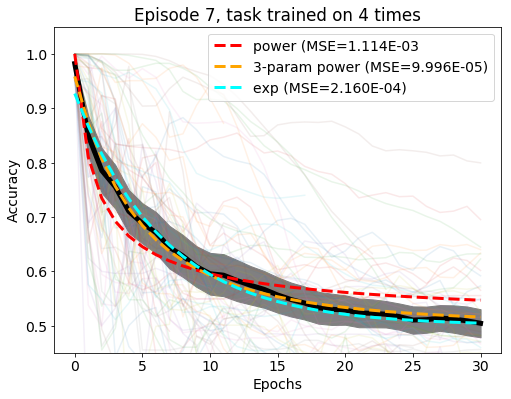

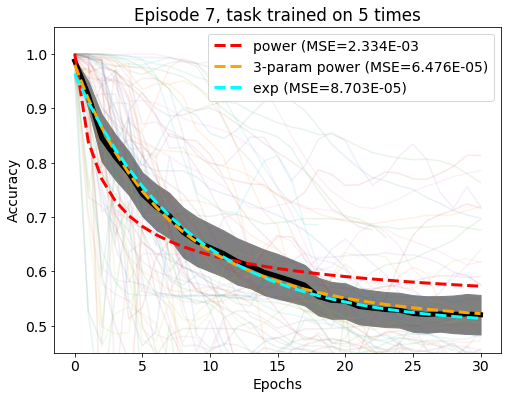

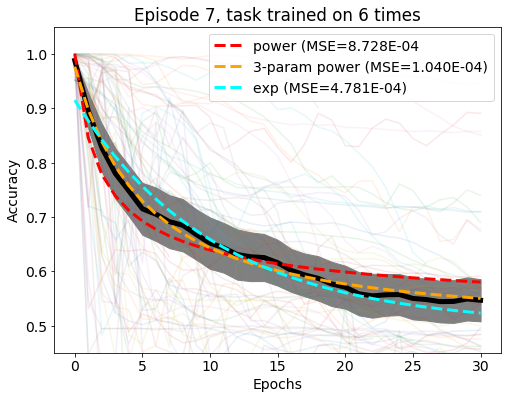

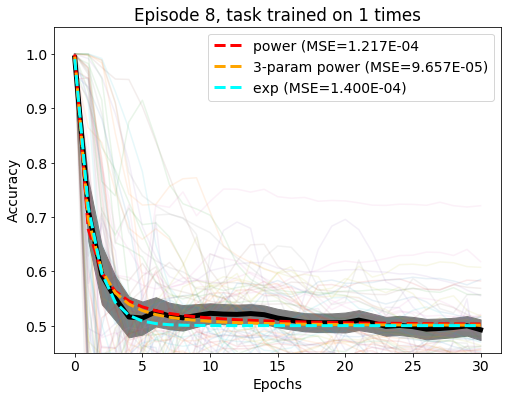

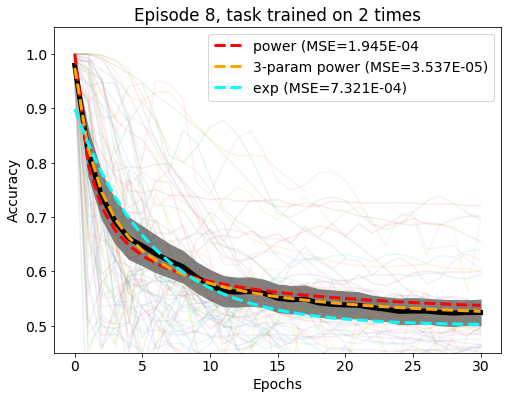

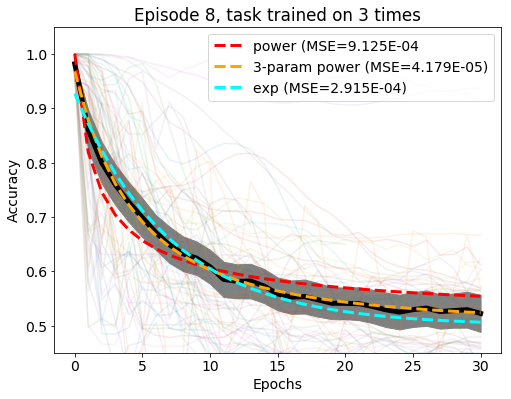

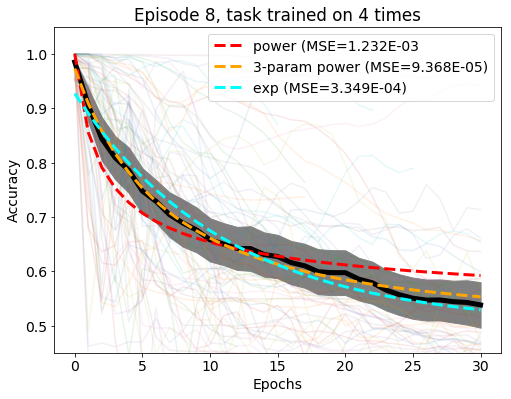

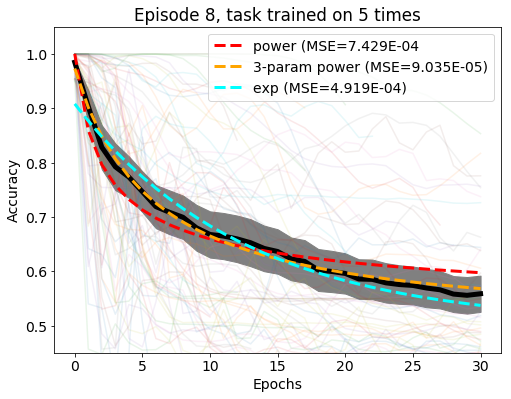

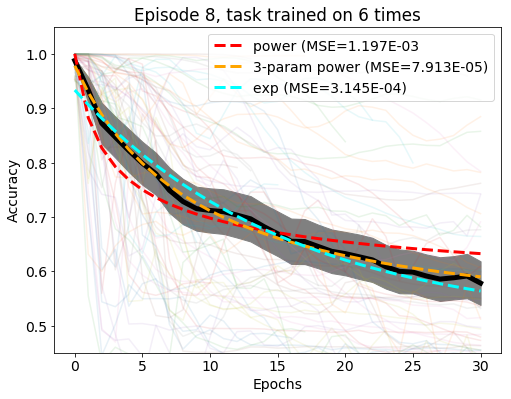

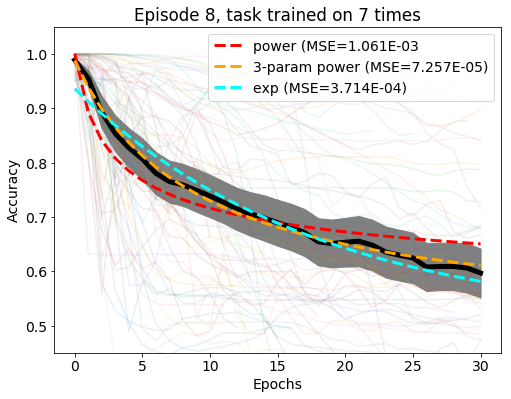

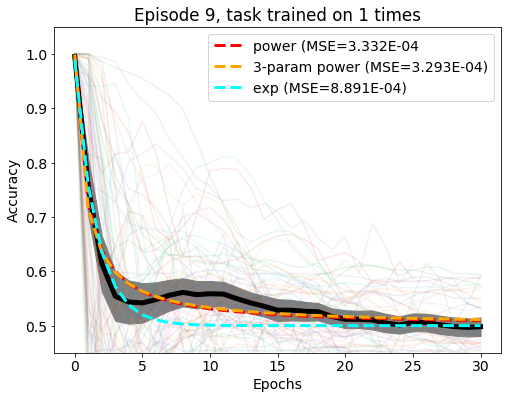

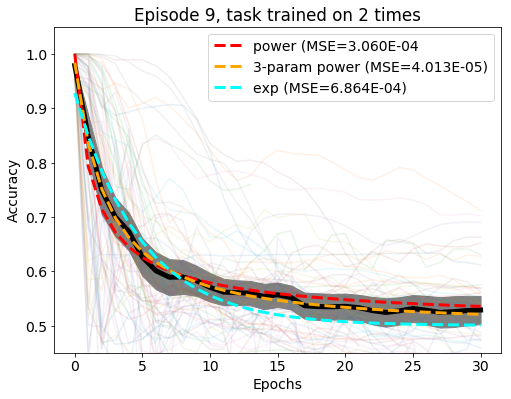

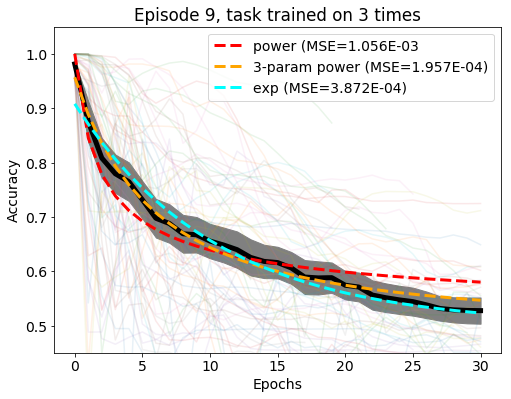

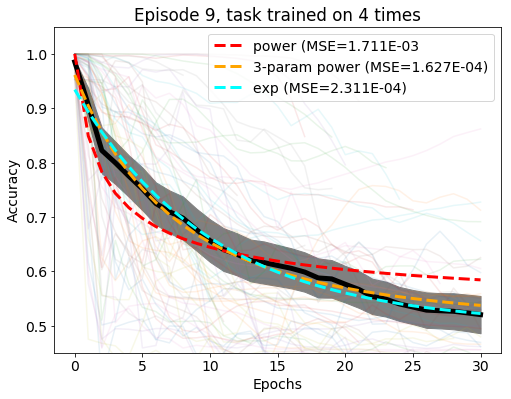

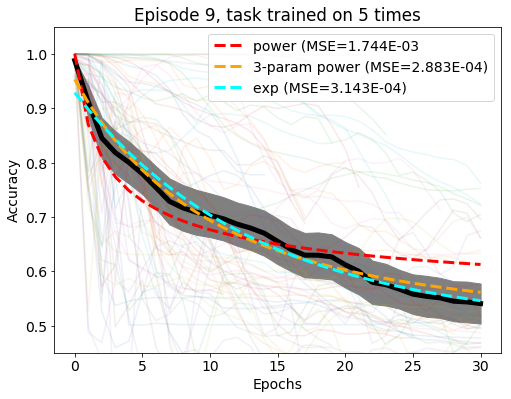

In [ ]:
ylim = (0.45, 1.05)
max_x = 31
num_tasks = 10

total_power_mse = 0
total_three_param_power_mse = 0
total_exp_mse = 0

power_decay_params = np.empty((2, 10, 10))
power_decay_params.fill(np.nan)

three_param_power_decay_params = np.empty((3, 10, 10))
three_param_power_decay_params.fill(np.nan)

exp_decay_params = np.empty((2, 10, 10))
exp_decay_params.fill(np.nan)

for episode_num in range(num_tasks):
    for times_trained in range(num_tasks):
        is_nan = np.isnan(forgetting_curves_raw_data[:, times_trained, episode_num])
        if not np.all(is_nan):
            plt.figure(figsize=(8, 6))
            plt.title(f'Episode {episode_num + 1}, task trained on {times_trained + 1} times')
            
            for sample in range(forgetting_curves_raw_data.shape[0]):
                data = forgetting_curves_raw_data[sample, times_trained, episode_num, :]
                nans = np.isnan(data)
                if not np.any(nans):
                    end = len(data)
                else:
                    end = nans.argmax()
                    
                end = min(max_x, end)
                plt.plot(np.arange(end), data[:end], alpha=0.1)
                
            all_point_data = forgetting_curves_raw_data[:, times_trained, episode_num, :]
            means = np.nanmean(all_point_data, axis=0)
            stds = np.nanstd(all_point_data, axis=0)
            non_nan_counts = np.count_nonzero(~np.isnan(all_point_data), axis=0)
            sems = np.divide(stds, non_nan_counts ** 0.5)
            
            plt.plot(means, linewidth=5, color='black')
            plt.fill_between(np.arange(means.shape[0]), means - 2 * sems, means + 2 * sems,
                             color='gray')
            
            (alpha_power, beta_power), _ = fit_model(all_point_data, power_decay,
                                                     bounds=[(0, 0), (1, 5)])
            power_decay_params[:, times_trained, episode_num] = (alpha_power, beta_power)
            power_preds = BASELINE + power_decay(np.arange(means.shape[0]), alpha_power, beta_power)
            power_mse = ((power_preds - means) ** 2).mean()
            total_power_mse += power_mse
            
            (alpha_power_3, beta_power_3, gamma_power_3), _ = fit_model(all_point_data, three_param_power_decay, 
                                                                        bounds=[(0, 0, 0), (1, np.inf, 5)])
            three_param_power_decay_params[:, times_trained, episode_num] = (alpha_power_3, beta_power_3, gamma_power_3)
            power_3_preds = BASELINE + three_param_power_decay(np.arange(means.shape[0]), alpha_power_3, beta_power_3, gamma_power_3)
            power_3_mse = ((power_3_preds - means) ** 2).mean()
            total_three_param_power_mse += power_3_mse
            
            (alpha_exp, beta_exp), _ = fit_model(all_point_data, exponential_decay,
                                                 bounds=[(0, 0), (1, 5)])
            exp_decay_params[:, times_trained, episode_num] = (alpha_exp, beta_exp)
            exp_preds = BASELINE + exponential_decay(np.arange(means.shape[0]), alpha_exp, beta_exp)
            exp_mse = ((exp_preds - means) ** 2).mean()
            total_exp_mse += exp_mse
            
            plt.plot(power_preds, linewidth=3, linestyle='--', color='red', label=f'power (MSE={power_mse:.3E}')
            plt.plot(power_3_preds, linewidth=3, linestyle='--', color='orange', label=f'3-param power (MSE={power_3_mse:.3E})')
            plt.plot(exp_preds, linewidth=3, linestyle='--', color='cyan', label=f'exp (MSE={exp_mse:.3E})')
            
            plt.ylim(ylim)
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
            plt.show()
            
            
print(f'Total power decay MSE: {total_power_mse}')
print(f'Total 3-param power decay MSE: {total_three_param_power_mse}')
print(f'Total exponential decay MSE: {total_exp_mse}')

## Fit tests for the three-parameter model and the two-parameter decay model

In [51]:
ylim = (0.45, 1.05)
max_x = 31
num_tasks = 10
train_test_split_index = 16

total_three_param_power_train_mse = 0
total_three_param_power_test_mse = 0
three_param_power_better = 0

total_exp_train_mse = 0
total_exp_test_mse = 0
exp_better = 0

x_train = np.arange(train_test_split_index)
x_test = np.arange(train_test_split_index, max_x)

for episode_num in range(num_tasks):
    for times_trained in range(num_tasks):
        is_nan = np.isnan(forgetting_curves_raw_data[:, times_trained, episode_num])
        if not np.all(is_nan):
            all_point_data = forgetting_curves_raw_data[:, times_trained, episode_num, :]
            means = np.nanmean(all_point_data, axis=0)
            train_means = means[:train_test_split_index]
            test_means = means[train_test_split_index:]
            
            train_data = all_point_data[:, :train_test_split_index]
            test_data = all_point_data[:, train_test_split_index:]
            
            (alpha_power_3, beta_power_3, gamma_power_3), _ = fit_model(train_data, three_param_power_decay, 
                                                                        bounds=[(0, 0, 0), (1, np.inf, 5)])
            
            power_3_train_preds = BASELINE + three_param_power_decay(x_train, alpha_power_3, beta_power_3, gamma_power_3)
            power_3_train_mse = ((power_3_train_preds - train_means) ** 2).mean()
            total_three_param_power_train_mse += power_3_train_mse
            
            power_3_test_preds = BASELINE + three_param_power_decay(x_test, alpha_power_3, beta_power_3, gamma_power_3)
            power_3_test_mse = ((power_3_test_preds - test_means) ** 2).mean()
            total_three_param_power_test_mse += power_3_test_mse
            
            (alpha_exp, beta_exp), _ = fit_model(train_data, exponential_decay,
                                                 bounds=[(0, 0), (1, 5)])
            
            exp_train_preds = BASELINE + exponential_decay(x_train, alpha_exp, beta_exp)
            exp_train_mse = ((exp_train_preds - train_means) ** 2).mean()
            total_exp_train_mse += exp_train_mse
            
            exp_test_preds = BASELINE + exponential_decay(x_test, alpha_exp, beta_exp)
            exp_test_mse = ((exp_test_preds - test_means) ** 2).mean()
            total_exp_test_mse += exp_test_mse
            
            if power_3_test_mse < total_exp_test_mse:
                three_param_power_better += 1
            else:
                exp_better += 1
            
print(f'3-param power decay: train MSE: {total_three_param_power_train_mse:.4f}, test MSE: {total_three_param_power_test_mse:.4f}, better: {three_param_power_better}')
print(f'exponential decay: train MSE: {total_exp_train_mse:.4f}, test MSE: {total_exp_test_mse:.4f}, better: {exp_better}')

3-param power decay: train MSE: 0.0047, test MSE: 0.0233, better: 45
exponential decay: train MSE: 0.0198, test MSE: 0.0192, better: 0


# More nuanced plotting

## With the exponential decay params

In [ ]:
DEFAULT_NAMES = ('alpha', 'beta')

def wrap_values_for_plotting(values, names=DEFAULT_NAMES):
    return [ [analysis.ResultSet(name=names[i], mean=values[i,:,:]) 
              for i in range(values.shape[0])] ]

NROWS = 2
NCOLS = 2
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 16

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.35)



axes = (plt.subplot(NROWS, NCOLS, 1), plt.subplot(NROWS, NCOLS, NCOLS + 1))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(exp_decay_params), data_index=0,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\alpha$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )


axes = (plt.subplot(NROWS, NCOLS, 2), plt.subplot(NROWS, NCOLS, NCOLS + 2))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(exp_decay_params), data_index=1,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\beta$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )



plots.save('workshop/forgetting_exp_param_values.pdf')
plt.show()






## With the power decay params

In [ ]:
DEFAULT_NAMES = ('alpha', 'beta')

def wrap_values_for_plotting(values, names=DEFAULT_NAMES):
    return [ [analysis.ResultSet(name=names[i], mean=values[i,:,:]) 
              for i in range(values.shape[0])] ]

NROWS = 2
NCOLS = 2
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 16

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.35)



axes = (plt.subplot(NROWS, NCOLS, 1), plt.subplot(NROWS, NCOLS, NCOLS + 1))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(power_decay_params), data_index=0,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\alpha$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )


axes = (plt.subplot(NROWS, NCOLS, 2), plt.subplot(NROWS, NCOLS, NCOLS + 2))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(power_decay_params), data_index=1,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\beta$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )



plots.save('workshop/forgetting_power_param_values.pdf')
plt.show()






## With the three-parameter power function

In [ ]:
DEFAULT_NAMES = ('alpha', 'beta', 'gamma')

def wrap_values_for_plotting(values, names=DEFAULT_NAMES):
    return [ [analysis.ResultSet(name=names[i], mean=values[i,:,:]) 
              for i in range(values.shape[0])] ]

NROWS = 2
NCOLS = 3
COL_WIDTH = 6
ROW_HEIGHT = 5 
WIDTH_SPACING = 2
HEIGHT_SPACING = 0

title_font_dict = TITLE_FONT_DICT.copy()
title_font_dict['pad'] = 16

multi_plot_font_dict = FONT_DICT.copy()
multi_plot_font_dict['fontsize'] = 18
    
figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
plt.subplots_adjust(hspace=0.4, wspace=0.35)



axes = (plt.subplot(NROWS, NCOLS, 1), plt.subplot(NROWS, NCOLS, NCOLS + 1))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(three_param_power_decay_params), 
                                            data_index=0,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\alpha$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )


axes = (plt.subplot(NROWS, NCOLS, 2), plt.subplot(NROWS, NCOLS, NCOLS + 2))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(three_param_power_decay_params), 
                                            data_index=1,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\beta$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )


axes = (plt.subplot(NROWS, NCOLS, 3), plt.subplot(NROWS, NCOLS, NCOLS + 3))
plots.plot_processed_results_all_dimensions(wrap_values_for_plotting(three_param_power_decay_params), 
                                            data_index=2,
                                            title='', 
                                            # ylim=ACCURACY_PLOT_YLIM, 
                                            plot_y_label='$\\gamma$ value',
                                            font_dict=FONT_DICT, times_trained_colormap=QUERY_ORDINAL_POSITION_COMORLAP, 
                                            tasks_trained_colormap=NUM_TIMES_TRAINED_COLORMAP,
                                            dimension_names=('',), dimension_indices=(0,),
                                            # num_tasks_trained_highlight_first_time='highlight',
                                            title_font_dict=title_font_dict, external_axes=axes,
                                            #save_path='workshop/22point5k_examples_accuracy.pdf'
                                           )



plots.save('workshop/forgetting_power_param_values.pdf')
plt.show()






## Heatmap piloting

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(exp_decay_params[0,:,:])

for episode_num in range(num_tasks):
    for times_trained in range(num_tasks):
        if not np.isnan(exp_decay_params[0, times_trained, episode_num]):
            ax.text(episode_num, times_trained, f'{exp_decay_params[0, times_trained, episode_num]:.2f}',
                    ha='center', va='center', color='w')
                    

In [ ]:
((exp_preds - means) ** 2).mean()

In [ ]:
times_trained = 6
episode_num = 7

(alpha_power, beta_power), _ = fit_model(forgetting_curves_raw_data[:, times_trained, episode_num, :], power_decay)
(alpha_exp, beta_exp), _ = fit_model(forgetting_curves_raw_data[:, times_trained, episode_num, :], exponential_decay)

plt.figure(figsize=(8, 6))
plt.title(f'Episode {episode_num + 1}, task trained on {times_trained + 1} times')

for sample in range(forgetting_curves_raw_data.shape[0]):
    data = forgetting_curves_raw_data[sample, times_trained, episode_num, :]
    nans = np.isnan(data)
    if not np.any(nans):
        end = len(data)
    else:
        end = nans.argmax()

    end = min(max_x, end)
    plt.plot(np.arange(end), data[:end])

means = np.nanmean(forgetting_curves_raw_data[:, times_trained, episode_num, :], axis=0)
stds = np.nanstd(forgetting_curves_raw_data[:, times_trained, episode_num, :], axis=0)
non_nan_counts = np.count_nonzero(~np.isnan(forgetting_curves_raw_data[:, 0, 1, :]), axis=0)
sems = np.divide(stds, non_nan_counts ** 0.5)

plt.plot(means, linewidth=5, color='black')
plt.fill_between(np.arange(means.shape[0]), means - 2 * sems, means + 2 * sems,
                 color='cyan')

plt.plot(np.arange(31), BASELINE + power_decay(np.arange(31), alpha_power, beta_power), 
         linewidth=3, linestyle='--', color='red', label='power')
plt.plot(np.arange(31), BASELINE + exponential_decay(np.arange(31), alpha_exp, beta_exp), 
         linewidth=3, linestyle='--', color='blue', label='exp')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
exp_decay_params

# Scratch work

In [ ]:
mean = np.nanmean(forgetting_curves_raw_data[:, 0, 1, :], axis=0)
mean, mean.shape

In [ ]:
std = np.nanstd(forgetting_curves_raw_data[:, 0, 1, :], axis=0)
std, std.shape

In [ ]:
c = np.count_nonzero(~np.isnan(forgetting_curves_raw_data[:, 0, 1, :]), axis=0)
c ** 0.5

In [ ]:
test_id = 'r6gc4st4'
r = api.run(forgetting_exp_pattern.format(run_id=test_id))

In [ ]:
hist = r.history(samples=2000)

In [ ]:
tasks_started = [f'Test Accuracy, Query #{current_task}' in hist for current_task in range(2, 11)]
tasks_started

In [ ]:
last_task = 2 + len(first_valid) - 1 - first_valid[::-1].index(True)
print(last_task)
hist[f'Test Accuracy, Query #{last_task}'].first_valid_index()

In [ ]:
hist[hist[f'Test Accuracy, Query #{last_task}'].first_valid_index() - 1:]

In [ ]:
'step_resumed_from' in r.config

In [ ]:
np.array(hist[1001:1021]['_timestamp']) - np.array(hist[1000:1020]['_timestamp'])

In [ ]:
hist[900:1100]['_timestamp'].diff().idxmax()

In [ ]:
hist[1000:1020]['_timestamp']

In [ ]:
current_run = r
current_df = hist

In [ ]:
step_resumed_from = current_run.config['step_resumed_from']
post_resume_step = current_df[900:1100]['_timestamp'].diff().idxmax()
print(step_resumed_from, post_resume_step)

In [ ]:
current_df[step_resumed_from - 2:step_resumed_from + 2]

In [ ]:
current_df[post_resume_step - 2:post_resume_step + 2]

In [ ]:
resumed_row = current_df[step_resumed_from:step_resumed_from + 1]
resumed_row

In [ ]:
tasks_active = [not resumed_row[f'Test Accuracy, Query #{i}'].isna().bool() for i in range(1, 11)]
print(tasks_active)
task_to_start = len(tasks_active) - 1 - tasks_active[::-1].index(True) + 2
print(task_to_start)

In [ ]:
hist_copy = current_df.copy()

In [ ]:
hist_copy.drop(range(step_resumed_from + 1, post_resume_step + 1), axis=0, inplace=True)

In [ ]:
hist_copy[step_resumed_from:10]

In [ ]:
hist_copy[step_resumed_from:step_resumed_from + 10]

In [ ]:
hist_copy.reset_index(inplace=True)

In [ ]:
results = analysis.parse_forgetting_results('r6gc4st4')

In [ ]:
results = np.expand_dims(results, 0)

In [ ]:
max_x = 31

for episode_num in range(10):
    for times_trained in range(10):
        is_nan = np.isnan(results[0, times_trained, episode_num])
        if not np.all(is_nan):
            plt.figure(figsize=(8, 6))
            plt.title(f'Episode {episode_num + 1}, task trained on {times_trained + 1} times')
            
            data = results[0, times_trained, episode_num, :]
            nans = np.isnan(data)
            if not np.any(nans):
                end = len(data)
            else:
                end = nans.argmax()

            end = min(max_x, end)
            plt.plot(data[:end])
            
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
            plt.show()

